# We now insert users' and movies' latents and see how can it improve our biases model

##Exploring the dataset and creating data structure for users and movies

 Downloading the MovieLens dataset (25 million ratings version)

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

--2024-12-25 18:43:02--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  52.2MB/s    in 5.2s    

2024-12-25 18:43:07 (48.0 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


Importing required libraries for preprocessing the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

Exploring the dataset

In [3]:
all_ratings = pd.read_csv('/content/ml-25m/ratings.csv')
all_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Calculate and display basic statistics about the dataset

In [8]:
num_users = len(all_ratings["userId"].unique())
num_movies = len(all_ratings["movieId"].unique())
num_ratings = len(all_ratings)
print("Number of users: ", num_users)
print("Number of movies: ", num_movies)
print("Number of ratings: ",num_ratings)

Number of users:  162541
Number of movies:  59047
Number of ratings:  25000095


unique mappings for user IDs and movie IDs

In [4]:
# Ids ==> indices
USER_TO_IDX = {userId: idx for idx, userId in enumerate(all_ratings["userId"].unique())}
MOVIE_TO_IDX = {movieId: idx for idx, movieId in enumerate(all_ratings["movieId"].unique())}

# indices ==> Ids
idx_to_user = list(USER_TO_IDX.keys())
idx_to_movie = list(MOVIE_TO_IDX.keys())

print("user_to_id mapping:", dict(list(USER_TO_IDX.items())[:5]))
print("movie_to_id mapping:", dict(list(MOVIE_TO_IDX.items())[:5]))

user_to_id mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
movie_to_id mapping: {296: 0, 306: 1, 307: 2, 665: 3, 899: 4}


* Create data structures for users and movies containing their respective movie/user IDs and ratings.
* users_data = [[(movieId, rating)...], [(movieId, rating) ...] ...]
* Same for movies_data except it contains userId

In [5]:
# Total numbers of users/movies
U = len(idx_to_user)
M = len(idx_to_movie)

users_data = [[] for _ in range(U)]
movies_data = [[] for _ in range(M)]

# iterate each row in the all_ratings DataFrame
for _, row in all_ratings.iterrows():
    user_id = int(row["userId"])
    movie_id = int(row["movieId"])
    rating = row["rating"]

    user_index = USER_TO_IDX[user_id]
    movie_index = MOVIE_TO_IDX[movie_id]

    # Append (movie_id, rating) to the user's data
    users_data[user_index].append((movie_id, rating))

    # Append (user_id, rating) to the movie's data
    movies_data[movie_index].append((user_id, rating))

print(f"Total users: {len(users_data)}, Total movies: {len(movies_data)}")
print("Sample users_data:", users_data[:2])  # first 2 users
print("Sample movies_data:", movies_data[:2]) # first 2 movies

Total users: 162541, Total movies: 59047
Sample users_data: [[(296, 5.0), (306, 3.5), (307, 5.0), (665, 5.0), (899, 3.5), (1088, 4.0), (1175, 3.5), (1217, 3.5), (1237, 5.0), (1250, 4.0), (1260, 3.5), (1653, 4.0), (2011, 2.5), (2012, 2.5), (2068, 2.5), (2161, 3.5), (2351, 4.5), (2573, 4.0), (2632, 5.0), (2692, 5.0), (2843, 4.5), (3448, 4.0), (3569, 5.0), (3949, 5.0), (4144, 5.0), (4308, 3.0), (4325, 5.0), (4422, 3.0), (4703, 4.0), (4973, 4.5), (5147, 4.0), (5269, 0.5), (5684, 2.0), (5767, 5.0), (5878, 4.0), (5912, 3.0), (5952, 4.0), (6016, 5.0), (6370, 4.5), (6377, 4.0), (6539, 3.5), (6711, 5.0), (6954, 3.5), (7209, 4.0), (7234, 4.5), (7318, 2.0), (7323, 3.5), (7327, 3.5), (7361, 5.0), (7365, 4.0), (7820, 2.5), (7937, 3.0), (7938, 2.5), (7939, 2.5), (7940, 4.5), (8014, 3.5), (8154, 5.0), (8327, 5.0), (8360, 4.0), (8405, 3.5), (8685, 1.0), (8729, 3.5), (8786, 4.0), (8873, 3.0), (8973, 4.0), (27193, 3.0), (27266, 4.5), (27721, 3.0), (31956, 3.5), (32591, 5.0)], [(1, 3.5), (62, 0.5), (110,

* Power plot:
    * This plot shows the distribution of how many ratings each movie has received.
    * A small number of movies are extremely popular and receive a disproportionate number of ratings, while the majority are less popular.
    * We used plt.loglog(), because the logarithmic scale makes it easier to see the trend.

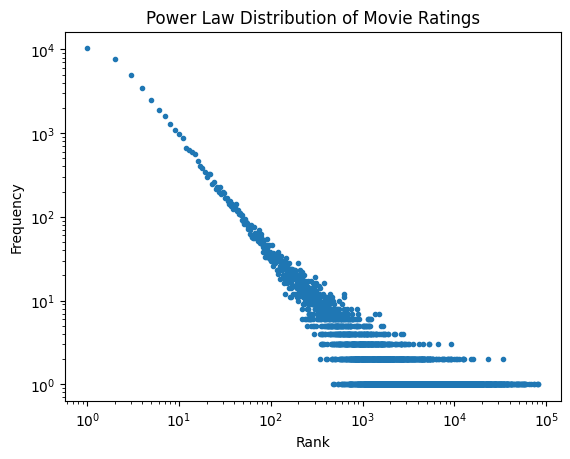

In [12]:
ratings_list = [len(movie_data) for movie_id, movie_data in enumerate(movies_data)]

ratings_list_dict = Counter(ratings_list)

plt.loglog(ratings_list_dict.keys(), ratings_list_dict.values(), ".")
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Power Law Distribution of Movie Ratings")
plt.show()

##Building the Biases + Latents model

* initialize user and movie biases with zeros.
* Initialize user/movie latent matrices with normal distribution

In [6]:
def init_biases(users_data, movies_data):
  user_biases = np.zeros(len(users_data))
  movie_biases= np.zeros(len(movies_data))
  return user_biases, movie_biases

def init_latent_matrices(num_users, num_movies, k, seed=None):
    if seed is not None:
      np.random.seed(seed)
    U_matrix = np.random.normal(size=(num_users, k), scale=1/np.sqrt(k))
    V_matrix =  np.random.normal(size=(num_movies, k), scale=1/np.sqrt(k))
    return U_matrix, V_matrix

*user/movie biases update functions*

* Equation for updating ith user bias:
$$b_u^{(i)} = \frac{\lambda \sum_{m \in M_u} (r_{um} - (u_u^Tv_m +  b_m))}{\lambda |M_u| + \gamma}$$
Where:
- $b_u^{(i)}$: Updated bias for user $u$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $b_m$: Current bias for movie $m$.
- $M_u$: Set of movies rated by user $u$.
- $\lambda$: Regularization parameter to control overfitting.
- $\gamma$: Regularization constant.
- $u,v$: latents for user and movie.

* Equation for updating ith movie bias:
$$b_m^{(i)} = \frac{\lambda \sum_{u \in U_m} (r_{um} - (u_m^Tv_u  + b_u))}{\lambda |U_m| + \gamma}$$
Where:
- $b_m^{(i)}$: Updated bias for movie $m$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $b_u$: Current bias for user $u$.
- $U_m$: Set of users who rated movie $m$.
- $\lambda$: Regularization parameter to control overfitting.
- $\gamma$: Regularization constant.

In [7]:
def update_user_biases_with_latent(user_id, users_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1):
      # Number of movies rated by user
      n = 0
      error = 0
      for movie_rating in users_data[user_id]:
        if movie_rating:
          n +=1
          movie_id, rating = movie_rating
          movie_index = MOVIE_TO_IDX[movie_id]
          u = U_matrix[user_id]
          v = V_matrix[movie_index]
          predicted_rating = np.dot(u, v) + movie_biases[movie_index]
          error += rating - predicted_rating
      regularized_term = lambda_ * n + gamma
      user_biases[user_id] = lambda_ * (error / regularized_term)

def update_movie_biases_with_latent(movie_id, movies_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1):
      # Number of users that rated this movie
      m = 0
      error = 0
      for user_rating in movies_data[movie_id]:
        if user_rating:
          m +=1
          user_id, rating = user_rating
          user_index = USER_TO_IDX[user_id]
          u = U_matrix[user_index]
          v = V_matrix[movie_id]
          predicted_rating = np.dot(u, v) + user_biases[user_index]
          error += rating - predicted_rating

      regularized_term =  lambda_ * m + gamma
      movie_biases[movie_id] = lambda_ * (error /regularized_term)



**Latent Update Functions**

* User-latent update equation:
$$u_u = (\lambda \sum_{m \in M_u} v_m v_m^T + \tau I)^{-1}(\lambda \sum_{m \in M_u} v_m r_{um})$$
Where:
- $u_u$: Latent vector for user $u$.
- $M_u$: Set of movies rated by user $u$.
- $v_m$: Latent vector for movie $m$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $\lambda$: Regularization parameter.
- $\tau$: Regularization constant for latent factors.
- $I$: Identity matrix for regularization.

* Movie-latent update equation:
$$v_m = (\lambda \sum_{u \in U_m} u_u u_u^T + \tau I)^{-1}(\lambda \sum_{u \in U_m} u_u r_{um})$$
Where:
- $v_m$: Latent vector for movie $m$.
- $U_m$: Set of users who rated movie $m$.
- $u_u$: Latent vector for user $u$.
- $r_{um}$: Rating given by user $u$ to movie $m$.
- $\lambda$: Regularization parameter.
- $\tau$: Regularization constant for latent factors.
- $I$: Identity matrix for regularization.



In [8]:
def update_user_latent(user_id, users_data, U_matrix, V_matrix , k, lambda_=0.1, tau=0.1):
    identity_mat = np.eye(k)
    n = 0
    term = np.zeros(k)
    term_inverse = np.zeros((k,k))

    for movie_rating in users_data[user_id]:
      if movie_rating:
        n +=1
        movie_id, rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]
        v = V_matrix[movie_index]
        term += v * rating
        term_inverse += np.outer(v,v)
    term *= lambda_
    term_inverse *= lambda_
    term_inverse += tau * identity_mat
    u = np.linalg.solve(term_inverse, term)
    U_matrix[user_id] = u

def update_movie_latent(movie_id, movies_data, U_matrix, V_matrix , k, lambda_=0.1, tau=0.1):
    identity_mat = np.eye(k)
    m = 0
    term = np.zeros(k)
    term_inverse = np.zeros((k,k))

    for user_rating in movies_data[movie_id]:
      if user_rating:
        m +=1
        user_id, rating = user_rating
        user_index = USER_TO_IDX[user_id]
        u = U_matrix[user_index]
        term += u * rating
        term_inverse += np.outer(u,u)
    term *= lambda_
    term_inverse *= lambda_
    term_inverse+=  tau*(identity_mat)
    v = np.linalg.solve(term_inverse, term)
    V_matrix[movie_id] = v



Negative Log Likelihood loss function \
$$L = \frac{\lambda}{2} \Sigma_{(m,n)\in D} (r_{mn} - (u_m^Tv_n + b_n + b_m))^2 + \frac{\gamma}{2} (\Sigma_u b_u^2 + \Sigma_n b_n^2) + \frac{\tau}{2} (\Sigma_m u_m^2 + \Sigma_n v_n^2) \
$$

In [9]:
def calc_loss(users_data, user_biases, movie_biases, U_matrix, V_matrix, lambda_=0.1, gamma=0.1, tau=0.1):
  total_loss = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]
        predicted_rating = np.dot(U_matrix[user_id].T,V_matrix[movie_index])+user_biases[user_id] + movie_biases[movie_index]
        total_loss += (rating - predicted_rating)**2

  user_latent_reg = np.sum(np.sum(U_matrix))
  movie_latent_reg = np.sum(np.sum(V_matrix))
  user_bias_sum  = np.dot(user_biases, user_biases)
  movie_bias_sum = np.dot(movie_biases, movie_biases)
  total_loss = lambda_*total_loss + gamma*user_bias_sum + gamma*movie_bias_sum + (tau/2)*user_latent_reg + (tau/2)*movie_latent_reg

  return 0.5*total_loss

Root Mean Squared Error \
$$ RMSE = \sqrt{\frac{1}{|D|}\Sigma_{(u.m)\in D} (r_{um} - (u_m^Tv_n+b_u + b_m))^2}$$

In [10]:
def calc_rmse(users_data, user_biases, movie_biases, U_matrix, V_matrix):
  squared_error = 0
  count = 0
  for user_id in range(len(users_data)):
    for movie_rating in users_data[user_id]:
      # Check for non-empty entries
      if movie_rating:
        movie_id , rating = movie_rating
        movie_index = MOVIE_TO_IDX[movie_id]

        predicted_rating = (np.dot(U_matrix[user_id].T,V_matrix[movie_index])
                                  + user_biases[user_id]
                                  + movie_biases[movie_index] )

        squared_error += (rating - predicted_rating)**2
        # Increment count of valid ratings
        count+=1

  rmse =  np.sqrt(squared_error/count)
  return rmse


Splitting the dataset into train and test datasets, each for the movies and users data

In [11]:
def split(users_data, movies_data, test_ratio=0.2):
    U = len(users_data)
    M = len(movies_data)

    users_data_train = [[] for _ in range(U)]
    users_data_test = [[] for _ in range(U)]
    movies_data_train = [[] for _ in range(M)]
    movies_data_test = [[] for _ in range(M)]

    for user_id, user_data in enumerate(users_data):
        for movie_rating in user_data:
            if np.random.rand() > test_ratio:
                # Train set
                users_data_train[user_id].append(movie_rating)

                # placeholder for missing test entries
                users_data_test[user_id].append(())
            else:
                # Test set
                users_data_test[user_id].append(movie_rating)

                # placeholder for missing train entries
                users_data_train[user_id].append(()) # None or ()

    for movie_id, movie_row in enumerate(movies_data):
      for user_rating in movie_row:
        if np.random.rand()>test_ratio:
          movies_data_train[movie_id].append(user_rating)
          movies_data_test[movie_id].append(())
        else:
          movies_data_test[movie_id].append(user_rating)
          movies_data_train[movie_id].append(())

    return users_data_train, users_data_test, movies_data_train, movies_data_test


Training the model

In [12]:
def train_model_with_latent(users_data, movie_biases, k, iterations,  lambda_, gamma, tau):
  users_data_train, users_data_test, movies_data_train, movies_data_test = split(users_data, movies_data)

  U_matrix, V_matrix = init_latent_matrices(len(users_data), len(movies_data), k, seed=10)
  user_biases , movie_biases = init_biases(users_data_train, movies_data_train)

  losses_list, rmse_train_list, rmse_test_list = [], [], []

  # initialize user/movie biases
  user_biases , movie_biases = init_biases(users_data_train, movies_data_train)
  for i in range(iterations):
    print(f"Iteration: ({i+1}/{iterations})")

    # Update user biases/latents
    for user_id in range(len(users_data_train)):
      update_user_biases_with_latent(user_id, users_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma )
      update_user_latent(user_id, users_data_train, U_matrix, V_matrix, k, lambda_, tau)

    # Update movie biases/latents
    for movie_id in range(len(movies_data_train)):
      update_movie_biases_with_latent(movie_id, movies_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma )
      update_movie_latent(movie_id, movies_data_train, U_matrix, V_matrix, k, lambda_, tau)



    # Calculate loss and RMSE values
    loss = calc_loss(users_data_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma, tau)
    rmse_train = calc_rmse(users_data_train, user_biases, movie_biases, U_matrix, V_matrix)
    rmse_test = calc_rmse(users_data_test, user_biases, movie_biases, U_matrix, V_matrix)

    # Store values in thier respective lists
    losses_list.append(loss)
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)

    print(f"Loss: ==> {loss}, RMSE (Train):==> {rmse_train}, RMSE (Test):==> {rmse_test}")

  return losses_list, rmse_train_list, rmse_test_list, user_biases, movie_biases, U_matrix, V_matrix


In [ ]:
k = 10
lambda_ = 0.1
gamma = 0.1
tau = 1
iterations = 10

loss_with_latent, rmse_train_with_latent, rmse_test_with_latent , user_biases, movie_biases, U_matrix, V_matrix= train_model_with_latent(users_data, movies_data, k, iterations, lambda_, gamma, tau)

Iteration: (1/10)
Loss: ==> 11164352.365415461, RMSE (Train):==> 3.1285767583409703, RMSE (Test):==> 3.039653240418536
Iteration: (2/10)
Loss: ==> 2660449.83348826, RMSE (Train):==> 1.5029631044714937, RMSE (Test):==> 1.5337532069325257
Iteration: (3/10)
Loss: ==> 659622.5576507589, RMSE (Train):==> 0.711570424348149, RMSE (Test):==> 0.7816096461940203
Iteration: (4/10)
Loss: ==> 632795.3808424071, RMSE (Train):==> 0.6957430087914742, RMSE (Test):==> 0.7703973716432346
Iteration: (5/10)
Loss: ==> 623567.8092060856, RMSE (Train):==> 0.6907144462546376, RMSE (Test):==> 0.7674491864052276
Iteration: (6/10)
Loss: ==> 618510.4400905353, RMSE (Train):==> 0.6882230935123365, RMSE (Test):==> 0.7662699338896946
Iteration: (7/10)
Loss: ==> 615334.3929541062, RMSE (Train):==> 0.6867623650179365, RMSE (Test):==> 0.7657365393039564
Iteration: (8/10)
Loss: ==> 613288.7931700363, RMSE (Train):==> 0.685813990747079, RMSE (Test):==> 0.7654769021727188
Iteration: (9/10)
Loss: ==> 612037.3491049658, RMSE

Plot of the results

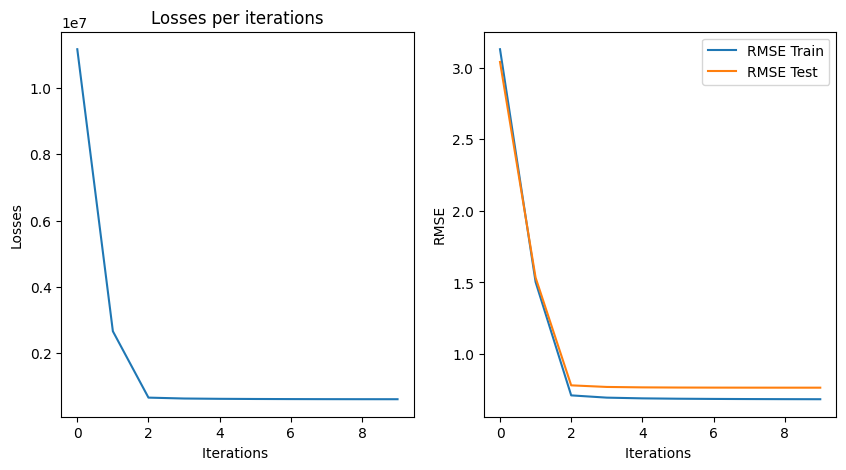

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_with_latent)
plt.xlabel("Iterations ")
plt.ylabel("Losses")
plt.title("Losses per iterations")

plt.subplot(1,2,2)
plt.plot(rmse_train_with_latent, label="RMSE Train")
plt.legend()
plt.xlabel("Iterations ")
plt.ylabel("RMSE")
plt.plot(rmse_test_with_latent, label="RMSE Test")
plt.legend()
plt.xlabel("Iterations ")
plt.ylabel("RMSE")
plt.title("RMSE per iterations")
plt.show()

##Testing the model with a dummy user

* We will interdocue a user with a single interaction (gave a single movie 5.0 rating) and see whhat would the model recoomend based on this interarction.

Loading the model parameters

In [13]:
data = np.load("//content/model_parameters_(20_0.1_0.1_1).npz")

# Access each parameter by key
rmse__train_losses = data['rmse_train_losses']
rmse_test_losses = data['rmse_test_losses']
train_losses = data['train_losses']
user_biases = data['user_biases']
movie_biases = data['movie_biases']
users_latent = data['users_latent']
movies_latent = data['movies_latent']

Loading Movies dataframe

In [14]:
all_movies = pd.read_csv('/content/ml-25m/movies.csv')
all_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Retrieve the title and id of a givven search

In [32]:
def retrieve_title_id(search):
    results = []
    for movie_id, movie_title in zip(all_movies["movieId"], all_movies["title"]):
        if search.lower() in movie_title.lower():
            results.append((movie_id, movie_title))
    return results
# combines each movie titles with its respective id
movies_dictionary = dict(zip(all_movies['movieId'], all_movies['title']))

In [24]:
# test
retrieve_title_id("toy")

[(1, 'Toy Story (1995)'),
 (2017, 'Babes in Toyland (1961)'),
 (2253, 'Toys (1992)'),
 (2480, 'Dry Cleaning (Nettoyage à sec) (1997)'),
 (3086, 'Babes in Toyland (1934)'),
 (3114, 'Toy Story 2 (1999)'),
 (4929, 'Toy, The (1982)'),
 (5843, 'Toy Soldiers (1991)'),
 (26033, 'Giants and Toys (Kyojin to gangu) (1958)'),
 (78062, 'Puppet Master vs. Demonic Toys (Puppet Master 9) (2004)'),
 (78499, 'Toy Story 3 (2010)'),
 (80141, 'Christmas Toy, The (1986)'),
 (81981, 'Toy, The (Le jouet) (1976)'),
 (83439, 'Toys in the Attic (1963)'),
 (90252, 'Devil Times Five (a.k.a. Peopletoys) (1974)'),
 (93574, 'Resurrect Dead: The Mystery of the Toynbee Tiles (2011)'),
 (106022, 'Toy Story of Terror (2013)'),
 (115875, 'Toy Story Toons: Hawaiian Vacation (2011)'),
 (115879, 'Toy Story Toons: Small Fry (2011)'),
 (116461, 'How the Toys Saved Christmas (1996)'),
 (119975, 'Silent Night, Deadly Night 5: The Toy Maker (1991)'),
 (120468, 'Toy Story Toons: Partysaurus Rex (2012)'),
 (120474, 'Toy Story That

In [29]:
dummy_user_data = [(1, 5.0)] # gave Toy story 5.0 rating

lambda_ = 1
gamma = 0.1
k = 20
tau = 1

for i in range(10):
  dummy_user_bias = 0
  dummy_user_latent = np.zeros(k)
  bias = 0
  num_movies = 0
  for (movie_id, rating) in dummy_user_data:
      movie_index = MOVIE_TO_IDX[movie_id]
      bias += rating - np.dot(dummy_user_latent ,movies_latent[movie_index]) - movie_biases[movie_index]
      num_movies += 1
  dummy_user_bias = (lambda_ * bias)/((lambda_* num_movies)+ gamma)

  term2 = np.zeros(k)
  term1 = np.zeros((k,k))
  c = 0
  for (movie_id, rating) in dummy_user_data:
      movie_index = MOVIE_TO_IDX[movie_id]
      term2 += movies_latent[movie_index] * (rating - movie_biases[movie_index] - dummy_user_bias)
      term1 += np.outer(movies_latent[movie_index], movies_latent[movie_index])
      c+=1
  term2 = lambda_* term2
  term1 = lambda_* term1 + (tau * np.identity(k))
  dummy_user_latent = np.linalg.solve(term1, term2)


Top-k recommendations for the dummy user

In [50]:
top_n_recommendations = 30  # Number of recommendations to display
recommended_movies = []

for movie_id, latent_vector in enumerate(movies_latent):
    predicted_rating = (
        0.05* movies_latent[movie_id]
        + np.dot(dummy_user_latent, latent_vector)
    )

    # Add the predicted rating and movie ID to recommendations list
    recommended_movies.append((predicted_rating[0], movie_id))

# Sort movies by predicted rating in descending order
recommended_movies.sort(reverse=True, key=lambda x: x[0])

# Display top N recommended movies
print(f"Top {top_n_recommendations} recommended movies for the dummy user:")
for rating, movie_id in recommended_movies[:top_n_recommendations]:
    for old, new in MOVIE_TO_IDX.items():
      if new == movie_id:
        movie_name = old
        break
    print(f"Movie ID: {movie_name}    ,      Title: {movies_dictionary[movie_name]}")

Top 30 recommended movies for the dummy user:
Movie ID: 1    ,      Title: Toy Story (1995)
Movie ID: 3114    ,      Title: Toy Story 2 (1999)
Movie ID: 78499    ,      Title: Toy Story 3 (2010)
Movie ID: 783    ,      Title: Hunchback of Notre Dame, The (1996)
Movie ID: 720    ,      Title: Wallace & Gromit: The Best of Aardman Animation (1996)
Movie ID: 745    ,      Title: Wallace & Gromit: A Close Shave (1995)
Movie ID: 364    ,      Title: Lion King, The (1994)
Movie ID: 2355    ,      Title: Bug's Life, A (1998)
Movie ID: 1148    ,      Title: Wallace & Gromit: The Wrong Trousers (1993)
Movie ID: 595    ,      Title: Beauty and the Beast (1991)
Movie ID: 60069    ,      Title: WALL·E (2008)
Movie ID: 588    ,      Title: Aladdin (1992)
Movie ID: 34    ,      Title: Babe (1995)
Movie ID: 4886    ,      Title: Monsters, Inc. (2001)
Movie ID: 6377    ,      Title: Finding Nemo (2003)
Movie ID: 2294    ,      Title: Antz (1998)
Movie ID: 594    ,      Title: Snow White and the Seven 

In [55]:
recommendations_df = pd.DataFrame(columns=['Movie ID', 'Title'])
for _, movie_id in recommended_movies[:top_n_recommendations]:
    for old, new in MOVIE_TO_IDX.items():
        if new == movie_id:
            movie_name = old
            break
    recommendations_df = pd.concat([recommendations_df, pd.DataFrame({'Movie ID': [movie_name], 'Title': [movies_dictionary[movie_name]],})], ignore_index=True)

recommendations_df

,Movie ID,Title
0,1,Toy Story (1995)
1,3114,Toy Story 2 (1999)
2,78499,Toy Story 3 (2010)
3,783,"Hunchback of Notre Dame, The (1996)"
4,720,Wallace & Gromit: The Best of Aardman Animatio...
5,745,Wallace & Gromit: A Close Shave (1995)
6,364,"Lion King, The (1994)"
7,2355,"Bug's Life, A (1998)"
8,1148,Wallace & Gromit: The Wrong Trousers (1993)
9,595,Beauty and the Beast (1991)
